# Project Luther

#### Purpose:
Using information we scrape from the web, build linear regression model from which we can learn whether specific GPU features can affect review scores on GPUBoss.com

#### Data:
Acquisition: scraping  
Storage: flat files  
Sources: GPUBoss.com

#### Skills:
- Basics of the web (HTML, Javascript)
- web scraping
- numpy and pandas
- statsmodel, scikit-learn

### Complete the following form prior to starting analysis:

#### Question / need:
- What is the linear regression of:
  * GPUBoss Review Score vs. 40+ GPU features?
- Can we predict GPUBoss review score with less GPU features? 5 features?

#### Description of my sample data:
- Table of different GPUs, their affiliated chipset, memory, core clock, GPUBoss Review score, and other specifications

#### Characteristics of each entry:
- Each entry provides at both categorical values (e.g. manufacturer; chipset) and continuous data (e.g. clock speed; memory)


## First import libraries we will need for analysis

In [257]:
import numpy as np
import pandas as pd

from __future__ import print_function, division

import requests

import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import re # for regex; e.g. text=re.compile('inserttexthere')

from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split # randomly creates test sets
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso

### Code to pull pcpartpicker HTML with BeautifulSoup (Raw)

### It appears the HTML pulled with 'requests' library does not contain all the information we need

### we will need to refer to selerium

In [258]:
# using selerium

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
#import time
from time import sleep, time
from random import randint
from IPython.core.display import clear_output
from warnings import warn

import os
chromedriver = "/Users/auyeus/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

#driver = webdriver.Chrome(chromedriver)
#driver.get(url)

### Helper function for scraping data from pcpartpicker.com

In [259]:
# pulling Video Card info
def get_gpu_info(gpu_index):
    '''
    input: GPU index
    output: appends gpu name, series, chipset, memory, core clock, rating count, and price
            to associated lists
    '''
    
    # pulling video card name
    video_name_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@class='tdname']"
    name = driver.find_element_by_xpath(video_name_selector).text
    gpu_name_list.append(name)
    
    # pulling gpu series name
    gpu_series_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[3]"
    series = driver.find_element_by_xpath(gpu_series_selector).text
    series_list.append(series)

    # pulling chipset name
    chipset_name_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@style='white-space:nowrap;']"
    chipset = driver.find_element_by_xpath(chipset_name_selector).text
    chipset_list.append(chipset)

    # pulling video card memory
    memory_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@style='text-align:right;']"
    memory = driver.find_element_by_xpath(memory_selector).text
    memory_list.append(memory)

    # pulling core clock
    core_clock_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@style='white-space:nowrap;text-align:right;']"
    core_clock = driver.find_element_by_xpath(core_clock_selector).text
    core_clock_list.append(core_clock)

    # pulling ratings total count
    ratings_count_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@class='inline-rating-sm']"
    ratings_count = driver.find_element_by_xpath(ratings_count_selector).text
    rating_count_list.append(ratings_count)

    # pulling price
    price_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@class='tdprice']"
    price = driver.find_element_by_xpath(price_selector).text
    price_list.append(price)

### Separate helper function for pulling ratings (converting stars to numeric values)

In [260]:
# need a separate script for pulling rating (stars)

def get_gpu_rating(gpu_index):
    '''
    input: GPU index
    output: returns GPU rating as a float
    '''
    #variable to track gpu rating
    gpu_rating = 0.0
    
    # iterate through each gpu rating
    gpu_stars = all_gpu_ratings[gpu_index].find_all('li')
    
    # for loop to get gpu_rating
    for star in gpu_stars:
        if star.attrs['class'] == ['full-star']:
            gpu_rating += 1
        elif star.attrs['class'] == ['half-star']:
            gpu_rating += 0.5
    
    return gpu_rating

## Script to scrape pcpartpicker.com:

## Script to scrape gpuboss.com

### Helper functions below for grabbing GPU specs and benchmarks from GPUBoss.com

In [261]:
# attempt to pull gpuboss review score
def get_gpuboss_score():
    try: output = soup.find(class_='score-text').text
    except: output = 'N/A'
    return output

# grab specific gpu spec
def get_gpu_spec(table_row_id):
    try: output = soup.find('tr',{'id':table_row_id}).find(class_='formatted-value some-value').text
    except: output = 'N/A'
    return output

# capture benchmark scores for:
# 'Manhattan (GFXBench 3.0)'
# 'T-Rex (GFXBench 3.0)'
def get_gpu_benchmark(benchmark,benchmark_list):
    try: 
        index_num = benchmark_list.index(benchmark)
        output = soup.find('div',{'id':'performance'}).find_all('div',{'href':'product-url'})[index_num].findNextSibling().text
    except: output = 'N/A'
    return output

# Script for Scraping website GPUBOSS

Create a list for each GPU specification we want to capture

## Scrape GPUBoss' main page ('sort' section)

- Capture the url for every GPU available on the main page and store in a list (gpu_url_list)
- Capture other information associated with each GPU, such as 'Release Date' and 'Manufacturer'

## Scrape each GPU's webpage

- go to each GPU's page and capture other available specifications (e.g. clock speeds; benchmark scores)

### Helper function to check specific GPU results are correct (compared to GPU results on website)

In [262]:
# check results of a specified-GPU
def check_outcome(gpu_index):
    print('Manufacturer:',manufacturers_list[gpu_index])
    print('chipset:',model_list[gpu_index])
    print('Release Date:',release_dates[gpu_index])
    print('GPUBoss Score:',gpuboss_scores[gpu_index])
    print('T-Rex GFX Score:',t_rex_gfx_scores[gpu_index])
    print('Manhattan GFX Score:',manhattan_gfx_scores[gpu_index])
    print('Market:',market_list[gpu_index])
    print('Clock Speed:',clock_speeds[gpu_index])
    print('Turbo Clock Speed:',turbo_clock_speeds[gpu_index])
    print('Shading units:',shading_units[gpu_index])
    print('Texture mapping units:',texture_mapping_units[gpu_index])
    print('Render output processors:',render_output_processors[gpu_index])
    print('Pixel Rate:',pixel_rates[gpu_index])
    print('Texture Rate:',texture_rates[gpu_index])
    print('Floating-point performance:',floating_point_performances[gpu_index])
    print('Memory clock speed:',memory_clock_speeds[gpu_index])
    print('Effective memory clock speed:',effective_memory_clock_speeds[gpu_index])
    print('Memory bus:',memory_bus_list[gpu_index])
    print('Memory:',memory_list_total[gpu_index])
    print('Memory Type:',memory_type_list[gpu_index])
    print('Memory bandwidth:',memory_bandwidth_list[gpu_index])
    print('TDP:',tdp_list[gpu_index])

In [263]:
#check_outcome(473)

## Store scraped data into DataFrame and pickle

### for pcpartpicker website

### Store GPUBoss data into DataFrame and pickle

### Code to remove a pickle file in the working directory

### Code to pickle dataframe

In [264]:
# pickle the data

from __future__ import print_function
import pickle

'''uncomment the line of code for the dataframe you wish to pickle data from'''
#data = test_df # for pcpartpicker website
#data = gpuboss_df # for gpuboss website


'''uncomment below to pickle'''
#with open('data/my_data_2.pkl','wb') as picklefile:
#     pickle.dump(data,picklefile) 
    
# my_data.pkl = pcpartpicker
# my_data_2.pkl = gpuboss

'uncomment below to pickle'

In [265]:
# del(data)
# data

In [266]:
# load pickle file - pcpartpicker website
with open('data/my_data.pkl','rb') as picklefile:
    df = pickle.load(picklefile)

In [267]:
# load pickle file - GPUBOSS website
with open('data/my_data_2.pkl','rb') as picklefile:
    df2 = pickle.load(picklefile)

### pcpartpicker dataframe - loaded from pickle my_data.pkl

In [268]:
df.head(5)

,GPU_Name,Series,Chipset,Memory,Core_Clock,Rating,Rating_Count,Price
0,Asus STRIX-GTX1080TI-11G-GAMING,STRIX GAMING,GeForce GTX 1080 Ti,11GB,1.49GHz,5.0,(21),$809.99
1,EVGA 06G-P4-6163-KR,SC GAMING,GeForce GTX 1060 6GB,6GB,1.61GHz,4.5,(56),$254.98
2,MSI GTX 1050 Ti GAMING X 4G,GAMING X 4G,GeForce GTX 1050 Ti,4GB,1.29GHz,4.5,(17),$189.98
3,MSI GeForce GTX 1060 6GT OCV1,GT OCV1,GeForce GTX 1060 6GB,6GB,1.54GHz,4.5,(13),$264.98
4,EVGA 08G-P4-5173-KR,SC GAMING ACX 3.0 Black Edition,GeForce GTX 1070,8GB,1.59GHz,4.5,(38),$364.98


### gpu boss dataframe - loaded from pickle my_data_2.pkl

In [269]:
df2.tail(5)

,release_date,manufacturer,chipset,dual_gpu,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed,...,pixel_rate,texture_rate,floating_point_performance,memory_clock_speed,effective_memory_clock_speed,memory_bus,memory,memory_type,memory_bandwidth,tdp
469,"Released February, 2008",Nvidia,GeForce 9300M G,No,85,N/A,N/A,N/A,Laptop,400 MHz,...,1.6 GPixel/s,3.2 GTexel/s,25.6 GFLOPS,600 MHz,"1,200 MHz",64 bit,256 MB,GDDR3,9.6 GB/s,13W
470,"Released October, 2008",Nvidia,GeForce 9200M,No,81,5.6,913.96,N/A,N/A,450 MHz,...,1.8 GPixel/s,3.6 GTexel/s,38.4 GFLOPS,N/A,N/A,N/A,N/A,N/A,N/A,12W
471,"Released July, 2008",ATi,Mobility Radeon HD 3410,No,62,N/A,N/A,N/A,Laptop,400 MHz,...,1.6 GPixel/s,1.6 GTexel/s,32 GFLOPS,400 MHz,800 MHz,64 bit,256 MB,DDR2,6.4 GB/s,7W
472,"Released January, 2008",ATi,Radeon X1050,No,49,N/A,N/A,N/A,Desktop,400 MHz,...,3.2 GPixel/s,3.2 GTexel/s,N/A,200 MHz,400 MHz,64 bit,128 MB,N/A,3.2 GB/s,24W
473,"Released March, 2015",Sapphire,Radeon R9 270 1024SP,No,,N/A,N/A,N/A,Desktop,900 MHz,...,29.76 GPixel/s,59.5 GTexel/s,"1,904.6 GFLOPS","1,200 MHz","4,800 MHz",256 bit,"2,048 MB",GDDR5,153.6 GB/s,150W


# Clean the Data

### Clean pcpartpicker data

In [270]:
# for rows where 'Price' is blank, update to 'N/A'
df.loc[df['Price']=='','Price'] = df['Price'].str.replace('','N/A')

# create a new column 'Float Price' for numerical analysis
df['Float_Price'] = df.loc[:,'Price']

# update column 'float price' by removing the '$' string and replacing 'N/A' with '0.0'
df.loc[:,'Float_Price'] = df['Float_Price'].str.replace('$','')
df.loc[df['Float_Price'] == 'N/A','Float_Price'] = df['Float_Price'].str.replace('N/A','0.0')

# set column 'Float Price' as a float data type
df.loc[:,'Float_Price'] = df['Float_Price'].astype(float)

# set column 'Rating Count' as an int data type for numerical analysis
df.loc[:,'Rating_Count'] = df['Rating_Count'].str.replace('(','')
df.loc[:,'Rating_Count'] = df['Rating_Count'].str.replace(')','').astype(int)

# ceate a new column 'Float Memory'
df['Float_Memory_MB'] = df.loc[:,'Memory']

# update column 'Float Memory (MB)' - remove string and change data type to float; normalize from GB to MB
df.loc[(df['Float_Memory_MB'].str.len()==4) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','000')
df.loc[(df['Float_Memory_MB'].str.len()==3) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','000')
df.loc[(df['Float_Memory_MB'].str.len()==5) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','00')
df.loc[(df['Float_Memory_MB'].str.len()==6) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','0')
df.loc[(df['Float_Memory_MB'].str.contains('.')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('.','') # remove periods
df.loc[:,'Float_Memory_MB'] = df['Float_Memory_MB'].str.replace('MB','').astype(float) # remove 'MB' string and set column as float data type

# create a new column 'Float Core Clock (MB)'
df['Float_Core_Clock_MHz'] = df.loc[:,'Core_Clock']

# update column 'Float Core Clock (MB)' - remove string and change data type to int; normalize from GHz to MHz
df.loc[(df['Float_Core_Clock_MHz'].str.len() == 4) & (df['Float_Core_Clock_MHz'].str.contains('GHz')),['Float_Core_Clock_MHz']] = df['Float_Core_Clock_MHz'].str.replace('GHz','000')
df.loc[(df['Float_Core_Clock_MHz'].str.len() == 6) & (df['Float_Core_Clock_MHz'].str.contains('GHz')),['Float_Core_Clock_MHz']] = df['Float_Core_Clock_MHz'].str.replace('GHz','00')
df.loc[(df['Float_Core_Clock_MHz'].str.len() == 7) & (df['Float_Core_Clock_MHz'].str.contains('GHz')),['Float_Core_Clock_MHz']] = df['Float_Core_Clock_MHz'].str.replace('GHz','0')
df.loc[:,'Float_Core_Clock_MHz'] = df['Float_Core_Clock_MHz'].str.replace('.','') # replace periods
df.loc[:,'Float_Core_Clock_MHz'] = df['Float_Core_Clock_MHz'].str.replace('MHz','') # remove MHz
df.loc[:,'Float_Core_Clock_MHz'] = df['Float_Core_Clock_MHz'].str.replace('N/A','0').astype(int) # remove 'N/A' string and set column as int data type


### clean gpuboss data

**things to clean:**
- set release date to MM - YYYY
- set passmark_score as integer / float
- set gpuboss_score as float
- set benchmark scores as float (t_rex + manhattan)
- set clock_speed to integer (normalize to MHz)
- set turbo_clock_speed to integer (normalize to MHz)
- set shading_units to integer
- set texture_mapping_units to integer
- set render_output_processors to integer
- set pixel_rate to float (in GPixel/s units)
- set texture_rate to float (in GTexel/s units)
- set floating_point_performance to float (in GFLOPS units)
- set memory_clock_speed to integer (in MHz units)
- set effective_memory_clock_speed to integer (normalize to MHz)
- set memory_bus to integer 
- set memory to integer (normalize to MB)
- set memory_bandwidth to integer / float (normalize to GB/s)
- set TDP to integer

**set as dummy variables:**
- set manufacturer as dummy variables
- set dual_gpu as dummy variables
- set market as dummy variables
- set memory_type as dummy variables

#### import the following for cleaning GPUBoss data

In [271]:
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

#### set data initially set to 'N/A' (from web-scrape) to NaN

In [272]:
df2.loc[(df2['gpuboss_score']=='N/A'),'gpuboss_score'] = np.nan
df2.loc[(df2['t_rex_gfx_score']=='N/A'),'t_rex_gfx_score'] = np.nan
df2.loc[(df2['manhattan_gfx_score']=='N/A'),'manhattan_gfx_score'] = np.nan
df2.loc[(df2['turbo_clock_speed']=='N/A'),'turbo_clock_speed'] = np.nan
df2.loc[(df2['shading_units']=='N/A'),'shading_units'] = np.nan
df2.loc[(df2['texture_rate']=='N/A'),'texture_rate'] = np.nan
df2.loc[(df2['floating_point_performance']=='N/A'),'floating_point_performance'] = np.nan
df2.loc[(df2['memory_clock_speed']=='N/A'),'memory_clock_speed'] = np.nan
df2.loc[(df2['effective_memory_clock_speed']=='N/A'),'effective_memory_clock_speed'] = np.nan
df2.loc[(df2['memory_bus']=='N/A'),'memory_bus'] = np.nan
df2.loc[(df2['memory']=='N/A'),'memory'] = np.nan
df2.loc[(df2['memory_bandwidth']=='N/A'),'memory_bandwidth'] = np.nan
df2.loc[(df2['tdp']=='N/A'),'tdp'] = np.nan
df2.loc[(df2['passmark_score']==' '),'passmark_score'] = np.nan

#### use sklearn to transform categorical data into dummy variables

Categorical data includes:
- manufacturer
- dual_gpu
- market
- memory_type

In [273]:
# manufacturer column: use sklearn to transform each category (manufacturer) as a column in the DataFrame
manufacturer_data_ = df2['manufacturer'].value_counts()
manufacturer_list_ = [[i] for i in list(df2['manufacturer'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(manufacturer_data_.index)])
one_hot_data_= one_hot.transform(manufacturer_list_)

manufacturer_model_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
df2 = pd.concat([df2, manufacturer_model_df], axis=1, join_axes=[df2.index])

# dual_gpu column: use sklearn to transform each category as a column in the DataFrame
data_ = df2['dual_gpu'].value_counts()
list_ = [[i] for i in list(df2['dual_gpu'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

model_df = pd.DataFrame(one_hot_data_,columns = ['no_dual_gpu','yes_dual_gpu'])
df2 = pd.concat([df2, model_df], axis=1, join_axes=[df2.index])

# market column: use sklearn to transform each category as a column in the DataFrame
market_data_ = df2['market'].value_counts()
market_list_ = [[i] for i in list(df2['market'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(market_data_.index)])
one_hot_data_= one_hot.transform(market_list_)

market_model_df = pd.DataFrame(one_hot_data_,columns = ['desktop_market','laptop_market','undefined_market'])
df2 = pd.concat([df2, market_model_df], axis=1, join_axes=[df2.index])

# memory_type column: use sklearn to transform each category as a column in the DataFrame
memory_type_data_ = df2['memory_type'].value_counts()
memory_type_list_ = [[i] for i in list(df2['memory_type'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(memory_type_data_.index)])
one_hot_data_= one_hot.transform(memory_type_list_)

memory_type_model_df = pd.DataFrame(one_hot_data_,columns = ['DDR2_memory','DDR3_memory','GDDR3_memory','GDDR5_memory','undefined_memory'])
df2 = pd.concat([df2, memory_type_model_df], axis=1, join_axes=[df2.index])

#### update release_date column by removing unnecessary strings and changing to DATETIME data type

In [274]:
# release_date column: update column 'release_date' by removing unnecessary strings and changing to DATETIME data type
df2.loc[:,'release_date'] = df2['release_date'].str.replace('Released ','')
df2.loc[:,'release_date'] = df2['release_date'].str.replace('First seen on ','')
df2.loc[:,'release_date'] = df2['release_date'].str.replace('Expected ','')
df2['release_date'] = pd.to_datetime(df2['release_date'],format='%B, %Y')

#### update other columns by:

- removing unnecessary strings
- changing data type to **int** or **float**

In [275]:
# passmark_score column: remove ',' string and set column as integer data type
df2.loc[:,'passmark_score'] = df2['passmark_score'].str.replace(',','').astype(float)

# gpuboss_score column: set column as integer data type
df2.loc[:,'gpuboss_score'] = df2['gpuboss_score'].astype(float) 

# t_rex_gfx_score column: remove ',' string and set column as float data type
df2.loc[:,'t_rex_gfx_score'] = df2['t_rex_gfx_score'].str.replace(',','').astype(float)

# manhattan_gfx_score column: remove ',' string and set column as float data type
df2.loc[:,'manhattan_gfx_score'] = df2['manhattan_gfx_score'].str.replace(',','').astype(float)

# clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename column to 'clock_speed_MHz'
df2.loc[:,'clock_speed'] = df2['clock_speed'].str.replace(',','')
df2.loc[:,'clock_speed'] = df2['clock_speed'].str.replace(' MHz','').astype(int)

# turbo_clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename column to 'turbo_clock_speed_MHz'
df2.loc[:,'turbo_clock_speed'] = df2['turbo_clock_speed'].str.replace(',','')
df2.loc[:,'turbo_clock_speed'] = df2['turbo_clock_speed'].str.replace(' MHz','').astype(float)

# shading_units column: remove ',' string and set column as integer data type
df2.loc[:,'shading_units'] = df2['shading_units'].str.replace(',','').astype(float)

# texture_mapping_units column: set column as integer data type
df2.loc[:,'texture_mapping_units'] = df2['texture_mapping_units'].astype(int)

# render_output_processors column: set column as integer data type
df2.loc[:,'render_output_processors'] = df2['render_output_processors'].astype(int)

# pixel_rate column: remove 'GPixel/s' string, set column as float data type, and rename column to 'pixel_rate_GPixel/s'
df2.loc[:,'pixel_rate'] = df2['pixel_rate'].str.replace(' GPixel/s','').astype(float)

# texture_rate column: remove 'GTexel/s' string, set column as float data type, and rename column to 'texture_rate_GTexel/s'
df2.loc[:,'texture_rate'] = df2['texture_rate'].str.replace(' GTexel/s','').astype(float)

# floating_point_performance column: remove ',' + 'GFLOPS' strings, set column as float data type, and rename to 'floating_point_performance_GFLOPS'
df2.loc[:,'floating_point_performance'] = df2['floating_point_performance'].str.replace(',','')
df2.loc[:,'floating_point_performance'] = df2['floating_point_performance'].str.replace(' GFLOPS','').astype(float)

# memory_clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename to 'memory_clock_speed_MHz'
df2.loc[:,'memory_clock_speed'] = df2['memory_clock_speed'].str.replace(',','')
df2.loc[:,'memory_clock_speed'] = df2['memory_clock_speed'].str.replace(' MHz','').astype(float)

# effective_memory_clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename to 'effective_memory_clock_speed_MHz'
df2.loc[:,'effective_memory_clock_speed'] = df2['effective_memory_clock_speed'].str.replace(',','')
df2.loc[:,'effective_memory_clock_speed'] = df2['effective_memory_clock_speed'].str.replace(' MHz','').astype(float)

# memory_bus column: remove ',' + 'bit' strings, set column as integer data type, and rename to 'memory_bus_bit'
df2.loc[:,'memory_bus'] = df2['memory_bus'].str.replace(',','')
df2.loc[:,'memory_bus'] = df2['memory_bus'].str.replace(' bit','').astype(float)

# memory column: remove ',' + 'bit' strings, set column as integer data type, and rename to 'memory_MB'
df2.loc[:,'memory'] = df2['memory'].str.replace(',','')
df2.loc[:,'memory'] = df2['memory'].str.replace(' MB','').astype(float)

# memory_bandwidth column: remove 'GB/s' string, set column as float data type, and rename to 'memory_bandwidth_GB/s'
df2.loc[:,'memory_bandwidth'] = df2['memory_bandwidth'].str.replace(',','')
df2.loc[:,'memory_bandwidth'] = df2['memory_bandwidth'].str.replace(' GB/s','').astype(float)

# tdp column: remove 'W' string, set column as integer data type, and rename to 'tdp_W'
df2.loc[:,'tdp'] = df2['tdp'].str.replace('W','').astype(float)

#### rename dataframe columns - specifically ones with measurement units (e.g. GFLOPS; MHz)

In [276]:
# rename columns with measurement units (e.g. GFLOPS)
df2.rename(columns={'memory_bandwidth':'memory_bandwidth_GB/s',
                    'memory':'memory_MB',
                    'memory_bus':'memory_bus_bit',
                    'effective_memory_clock_speed':'effective_memory_clock_speed_MHz',
                    'memory_clock_speed_MHz':'memory_clock_speed_MHz',
                    'floating_point_performance':'floating_point_performance_GFLOPS',
                    'texture_rate':'texture_rate_GTexel/s',
                    'pixel_rate':'pixel_rate_GPixel/s',
                    'turbo_clock_speed':'turbo_clock_speed_MHz',
                    'clock_speed':'clock_speed_MHz',
                    'memory':'memory_MB',
                    'tdp':'tdp_W',
                    'memory_bandwidth':'memory_bandwidth_GB/s'}, inplace=True)

#### sort dataframe by date; reset index

In [277]:
df2 = df2.sort_values(by=['release_date']).reset_index(drop=True)

## Check clean data

In [278]:
# check gpuboss_score column to ensure there are no extremes
df2.describe().loc[['min', 'max'], 'gpuboss_score'] # looks like it is in-line with the rating system (0 to 10)

min    2.8
max    9.9
Name: gpuboss_score, dtype: float64

In [279]:
df2.describe()

,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,clock_speed_MHz,turbo_clock_speed_MHz,shading_units,texture_mapping_units,render_output_processors,pixel_rate_GPixel/s,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
count,473.000000,267.000000,301.000000,244.000000,474.000000,150.000000,473.000000,474.000000,474.000000,474.000000,...,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,1867.854123,6.489139,3443.900963,3096.507541,754.611814,1002.593333,650.477801,48.455696,18.080169,14.804283,...,0.959916,0.040084,0.436709,0.500000,0.063291,0.056962,0.267932,0.206751,0.445148,0.023207
std,2343.137541,0.875306,4641.514931,2268.983720,203.884386,220.152391,958.019276,61.785648,18.917477,20.928190,...,0.196364,0.196364,0.496502,0.500528,0.243743,0.232015,0.443350,0.405403,0.497507,0.150719
min,49.000000,2.800000,94.430000,284.470000,300.000000,550.000000,8.000000,4.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,443.000000,6.000000,2066.150000,1743.847500,600.000000,855.000000,96.000000,16.000000,8.000000,3.600000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,879.000000,6.300000,3346.570000,3377.340000,725.000000,967.000000,384.000000,32.000000,16.000000,7.380000,...,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2217.000000,6.900000,3358.520000,3713.185000,900.000000,1088.250000,720.000000,56.000000,24.000000,16.240000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,13373.000000,9.900000,63092.870000,26305.730000,1607.000000,1759.000000,8192.000000,512.000000,128.000000,139.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Save cleaned gpuboss.com data (pickle)

In [280]:
# new DataFrame with cleaner data
df_updated_2 = df2

# save updated DataFrame with Pickle - dump into new file
with open('data/my_data_2_updated.pkl','wb') as picklefile:
    pickle.dump(df_updated_2,picklefile)

In [281]:
# load pickle file
with open('data/my_data_2_updated.pkl','rb') as picklefile:
    df_updated_2 = pickle.load(picklefile)

In [282]:
df_updated_2.columns

Index(['release_date', 'manufacturer', 'chipset', 'dual_gpu', 'passmark_score',
       'gpuboss_score', 't_rex_gfx_score', 'manhattan_gfx_score', 'market',
       'clock_speed_MHz', 'turbo_clock_speed_MHz', 'shading_units',
       'texture_mapping_units', 'render_output_processors',
       'pixel_rate_GPixel/s', 'texture_rate_GTexel/s',
       'floating_point_performance_GFLOPS', 'memory_clock_speed',
       'effective_memory_clock_speed_MHz', 'memory_bus_bit', 'memory_MB',
       'memory_type', 'memory_bandwidth_GB/s', 'tdp_W', 'AMD', 'ASUS', 'ATi',
       'BIOSTAR', 'Colorful', 'Diamond', 'EVGA', 'GIGABYTE', 'Generic', 'HIS',
       'Leadtek', 'MSI', 'Nvidia', 'PowerColor', 'SPARKLE', 'Sapphire', 'XFX',
       'ZOTAC', 'no_dual_gpu', 'yes_dual_gpu', 'desktop_market',
       'laptop_market', 'undefined_market', 'DDR2_memory', 'DDR3_memory',
       'GDDR3_memory', 'GDDR5_memory', 'undefined_memory'],
      dtype='object')

# visualization with seaborn

In [283]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [284]:
len(df_updated_2['gpuboss_score'].dropna()) # number of GPUs with gpuboss ratings

267

In [285]:
# number of GPUs with high rating, out of 267 GPUs with a valid gpuboss score
len(df_updated_2.loc[df_updated_2['gpuboss_score']>8.0]) 

11

Saving graph to: images/review_hist.svg


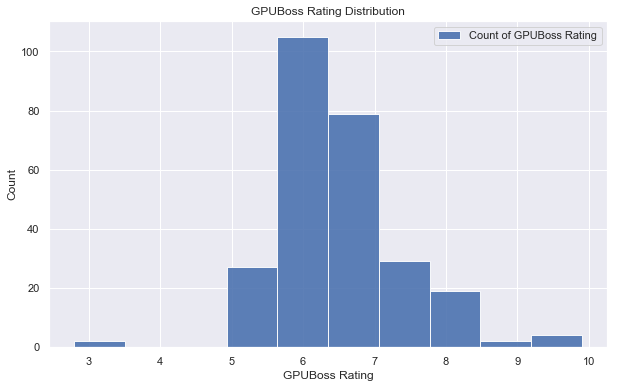

In [286]:
# histogram of video card ratings from gpuboss - only 11 video cards have a rating > 8.0
sns.set()
plt.figure(figsize=(10,6))
plt.hist(df_updated_2['gpuboss_score'].dropna(), alpha=0.9,label='Count of GPUBoss Rating')
plt.title('GPUBoss Rating Distribution')
plt.xlabel('GPUBoss Rating')
plt.ylabel('Count')
plt.legend();

# Save options
save = 'images/review_hist'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

### Move column 'gpuboss_score to the front of the DataFrame; new DataFrame: df_updated_3

In [287]:
df_updated_3 = df_updated_2[['gpuboss_score'] + [c for c in df_updated_2 if c not in ['gpuboss_score']]]

In [288]:
df_updated_3.head(3) # head of data

,gpuboss_score,release_date,manufacturer,chipset,dual_gpu,passmark_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
0,NaN,2008-01-01,ATi,Radeon X1050,No,49.0,NaN,NaN,Desktop,400,...,1,0,1,0,0,0,0,0,0,1
1,NaN,2008-01-01,ATi,Mobility Radeon HD 3650,No,216.0,1704.69,NaN,Laptop,500,...,1,0,0,1,0,0,0,1,0,0
2,NaN,2008-01-01,Nvidia,GeForce 8800 GS,No,551.0,NaN,NaN,Desktop,550,...,1,0,1,0,0,0,0,1,0,0


### develop a DataFrame with only rows that have gpuboss rating

In [289]:
df_train = df_updated_3.loc[df_updated_3['gpuboss_score'].notnull()]

In [290]:
df_train.head(3)

,gpuboss_score,release_date,manufacturer,chipset,dual_gpu,passmark_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
12,6.2,2008-02-01,Nvidia,GeForce GT 9600,No,739.0,NaN,NaN,Desktop,650,...,1,0,1,0,0,0,1,0,0,0
29,6.4,2008-06-01,ATi,Radeon HD 4850,No,1028.0,3357.10,NaN,Desktop,625,...,1,0,1,0,0,0,0,1,0,0
31,6.2,2008-07-01,Nvidia,GeForce GT 9800,No,716.0,3307.06,NaN,Desktop,600,...,1,0,1,0,0,0,0,1,0,0


### Columns to drop (in order to fit data into linear regression / statsmodel):
- manufacturer
- chipset
- dual_gpu
- market
- memory_type

### Columns to drop (no correlation with gpuboss score):
- BIOSTAR
- HIS

In [291]:
# drop categorical features that have already been transformed to dummy variables
df_train = df_train.drop(['manufacturer','chipset','dual_gpu','market','memory_type'], axis = 1)

# drop features that are not correlated with gpuboss_score
df_train = df_train.drop(['BIOSTAR','HIS'], axis = 1)

### convert datetime values into numerical values

In [292]:
df_train['release_date']=df_train['release_date'].map(datetime.toordinal)

### We will use K-Nearest Neighbor (KNN) to handle missing data

In this method, k neighbors are chosen based on some distance measure and their average is used as an imputation estimate. The method requires the selection of the number of nearest neighbors, and a distance metric. KNN can predict both discrete attributes (the most frequent value among the k nearest neighbors) and continuous attributes (the mean among the k nearest neighbors)
The distance metric varies according to the type of data:
1. Continuous Data: The commonly used distance metrics for continuous data are Euclidean, Manhattan and Cosine
2. Categorical Data: Hamming distance is generally used in this case. It takes all the categorical attributes and for each, count one if the value is not the same between two points. The Hamming distance is then equal to the number of attributes for which the value was different.

In [293]:
from fancyimpute import KNN    

# set df_train as numpy array for KNN
df_train_array = df_train.select_dtypes(include=[np.float,np.int]).as_matrix()

# Use 5 nearest rows which have a feature to fill in each row's missing features
df_train_filled = pd.DataFrame(KNN(k=5).fit_transform(df_train_array),columns=df_train.columns,index=df_train.index)

Imputing row 1/267 with 3 missing, elapsed time: 0.021
Imputing row 101/267 with 1 missing, elapsed time: 0.024
Imputing row 201/267 with 4 missing, elapsed time: 0.025


### reset the index

In [294]:
df_train_filled = df_train_filled.reset_index(drop=True)

In [295]:
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 45 columns):
gpuboss_score                        267 non-null float64
release_date                         267 non-null float64
passmark_score                       267 non-null float64
t_rex_gfx_score                      267 non-null float64
manhattan_gfx_score                  267 non-null float64
clock_speed_MHz                      267 non-null float64
turbo_clock_speed_MHz                267 non-null float64
shading_units                        267 non-null float64
texture_mapping_units                267 non-null float64
render_output_processors             267 non-null float64
pixel_rate_GPixel/s                  267 non-null float64
texture_rate_GTexel/s                267 non-null float64
floating_point_performance_GFLOPS    267 non-null float64
memory_clock_speed                   267 non-null float64
effective_memory_clock_speed_MHz     267 non-null float64
memory_bus_bit           

### save KKN-filled DataFrame via Pickle

In [296]:
# save updated DataFrame with Pickle - dump into new file
with open('data/df_train_filled.pkl','wb') as picklefile:
    pickle.dump(df_train_filled,picklefile)

In [297]:
# load pickle file
with open('data/df_train_filled.pkl','rb') as picklefile:
    df_train_filled = pickle.load(picklefile)

# Statistical Modelling with statsmodel.formula.api + sklearn

In [298]:
# for statsmodel
import statsmodels.formula.api as smf

# for scikitlearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# for plotting linear regressions
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### initial statsmodels summary

In [299]:
# define the features matrix (X_train) + response variable (y_train)
X = df_train_filled.iloc[:,1:]
y = df_train_filled.iloc[:,0]

# Define the model
lm1 = smf.ols('y ~ X',data=df_train_filled)

# Fit the model
fit1 = lm1.fit()

# Check out the results
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     10.37
Date:                Sat, 20 Oct 2018   Prob (F-statistic):           8.24e-33
Time:                        16:49:58   Log-Likelihood:                -203.65
No. Observations:                 267   AIC:                             489.3
Df Residuals:                     226   BIC:                             636.4
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.5198     30.878      0.956      0.340     -31.325      90.365
X[0]       -7.957e-05   8.83e-05     -0.901      0.369      -0.000    9.45e-05
X[1]        8.258e-05    6.5e-05      1.271      0.205   -4.55e-05       0.000
X[2]        4.418e-06   1.01e-05      0.435      0.664   -1.56e-05    2.44e-05
X[3]        4.717e-05    2.7e-05      1.749      0.082   -5.97e-06       0.000
X[4]           0.0002      0.000      0.363      0.717      -0.001       0.001
X[5]           0.0022      0.000      4.488      0.000       0.001       0.003
X[6]           0.0007      0.000      1.789      0.075   -7.32e-05       0.002
X[7]          -0.0056      0.007     -0.800      0.424      -0.019       0.008
X[8]           0.0238      0.011      2.161      0.032       0.002       0.046
X[9]          -0.0182      0.010     -1.772      0.078      -0.038       0.002
X[10]      -1.502e-05      0.008     -0.002      0.999      -0.016       0.016
X[11]          0.0001      0.000      0.402      0.688      -0.000       0.001
X[12]          0.0001      0.000      0.492      0.623      -0.000       0.001
X[13]         -0.0001   9.36e-05     -1.350      0.178      -0.000     5.8e-05
X[14]         -0.0004      0.000     -2.981      0.003      -0.001      -0.000
X[15]      -3.626e-05   3.69e-05     -0.982      0.327      -0.000    3.65e-05
X[16]          0.0030      0.001      2.047      0.042       0.000       0.006
X[17]         -0.0063      0.002     -3.966      0.000      -0.010      -0.003
X[18]          1.8999      1.973      0.963      0.337      -1.988       5.788
X[19]          1.6532      2.001      0.826      0.409      -2.289       5.595
X[20]          1.4634      1.907      0.768      0.444      -2.293       5.220
X[21]          1.7591      1.989      0.885      0.377      -2.159       5.678
X[22]          1.9219      2.008      0.957      0.340      -2.035       5.879
X[23]          2.1640      1.968      1.100      0.273      -1.714       6.042
X[24]          1.8142      2.024      0.897      0.371      -2.173       5.802
X[25]          1.7085      1.954      0.874      0.383      -2.143       5.560
X[26]          2.1958      1.993      1.102      0.272      -1.731       6.123
X[27]          1.2454      1.944      0.641      0.522      -2.585       5.076
X[28]          2.1544      1.945      1.108      0.269      -1.678       5.987
X[29]          1.2412      1.959      0.634      0.527      -2.618       5.101
X[30]          1.8891      2.021      0.935      0.351      -2.092       5.871
X[31]          1.9454      1.957      0.994      0.321      -1.911       5.802
X[32]          1.9041      1.987      0.958      0.339      -2.011       5.819
X[33]          2.5602      2.003      1.278      0.203      -1.387       6.508
X[34]         15.1387     15.421      0.982      0.327     -15.249      45.527
X[

In [300]:
df_train_filled.corr()

,gpuboss_score,release_date,passmark_score,t_rex_gfx_score,manhattan_gfx_score,clock_speed_MHz,turbo_clock_speed_MHz,shading_units,texture_mapping_units,render_output_processors,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
gpuboss_score,1.000000,0.409805,0.688057,0.364252,0.451478,0.555636,0.627362,0.553429,0.532667,0.589841,...,-0.103994,0.103994,0.112329,-0.106926,-0.011081,-0.134267,-0.227493,-0.165233,0.338552,-0.000053
release_date,0.409805,1.000000,0.523384,0.164474,0.215092,0.679075,0.597825,0.399467,0.331146,0.315130,...,-0.022692,0.022692,-0.172413,-0.020663,0.336918,-0.186538,0.028221,-0.368745,0.257487,-0.034691
passmark_score,0.688057,0.523384,1.000000,0.378478,0.443947,0.655017,0.698316,0.816230,0.800365,0.846022,...,-0.205384,0.205384,0.258232,-0.348973,0.153123,-0.122659,-0.415004,-0.243228,0.534218,0.041208
t_rex_gfx_score,0.364252,0.164474,0.378478,1.000000,0.616925,0.214841,0.255966,0.248384,0.241853,0.378054,...,0.002412,-0.002412,0.123978,-0.115769,-0.016118,-0.074517,-0.138857,-0.075630,0.195599,-0.016254
manhattan_gfx_score,0.451478,0.215092,0.443947,0.616925,1.000000,0.350055,0.421582,0.347346,0.357170,0.425216,...,-0.065759,0.065759,0.121363,-0.132352,0.017158,-0.157099,-0.266972,-0.141194,0.368622,-0.007390
clock_speed_MHz,0.555636,0.679075,0.655017,0.214841,0.350055,1.000000,0.863153,0.446891,0.381445,0.444751,...,-0.030728,0.030728,0.178539,-0.288367,0.187394,-0.141957,-0.144217,-0.285437,0.361155,-0.064746
turbo_clock_speed_MHz,0.627362,0.597825,0.698316,0.255966,0.421582,0.863153,1.000000,0.457793,0.401209,0.494616,...,-0.041292,0.041292,0.128682,-0.282301,0.263974,-0.121511,-0.227529,-0.251532,0.381769,0.012055
shading_units,0.553429,0.399467,0.816230,0.248384,0.347346,0.446891,0.457793,1.000000,0.971770,0.872612,...,-0.568477,0.568477,0.235348,-0.273694,0.062766,-0.106219,-0.339060,-0.190235,0.378575,0.182124
texture_mapping_units,0.532667,0.331146,0.800365,0.241853,0.357170,0.381445,0.401209,0.971770,1.000000,0.883071,...,-0.602752,0.602752,0.248741,-0.267476,0.028608,-0.102248,-0.353369,-0.171592,0.387729,0.158987
render_output_processors,0.589841,0.315130,0.846022,0.378054,0.425216,0.444751,0.494616,0.872612,0.883071,1.000000,...,-0.545887,0.545887,0.267573,-0.266068,-0.006723,-0.114788,-0.382504,-0.210300,0.466033,0.088636


## Correlation between response variable + all the features observed initially

Saving graph to: images/initial_corr_heatmap.svg


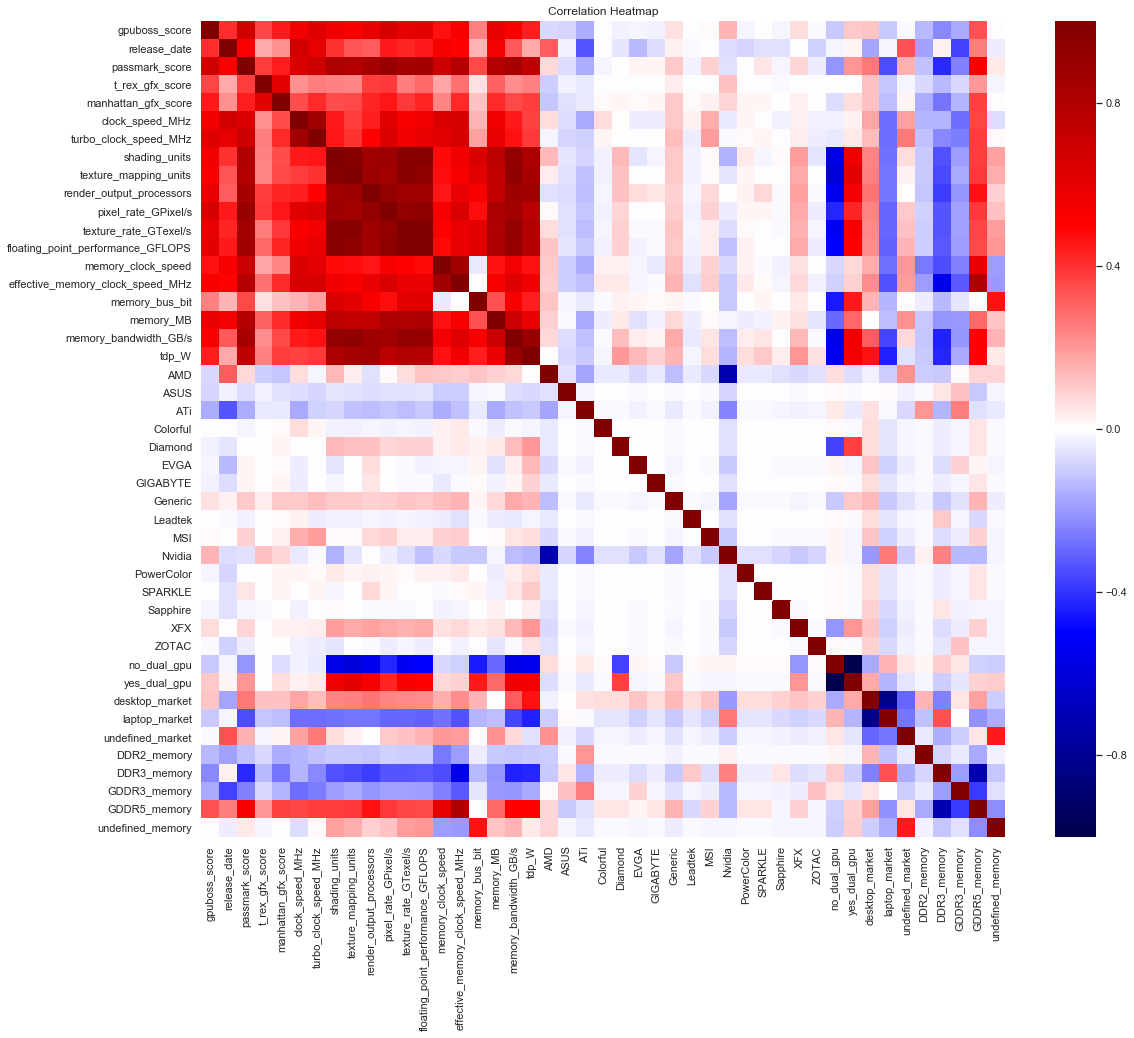

In [301]:
# example of a better corr matrix
plt.figure(figsize=(18,15))
plt.title('Correlation Heatmap')
sns.heatmap(df_train_filled.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

# Save options
save = 'images/initial_corr_heatmap'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

## Feature Selection

Given the large number of features with high p-values (based on t-scores), we can go ahead and remove some from the model
- Remove features with high p-values
- Remove features that are not really correlated with GPUBoss Review Score

### Let's use feature_selection from sklearn to narrow our features

Helper function to capture only GPU features whose beta coefficients' p-values of F-scores are less than 0.02

In [302]:
from sklearn import feature_selection as f_select

def feature_select(X_df):
    est = LinearRegression()
    sig_columns = [] # used to capture columns from X that have low p-values
    pvals = []

    # iterate and find features with p-values < .02
    for feature in X.columns:
        pval = f_select.f_regression(X[[feature]],y)
        #print(feature,pval)
        if pval[1][0] < .02:
            sig_columns.append(feature)
            pvals.append(pval[1][0])

    # save features with low p-values to new variable
    X_select = X[sig_columns]
    return X_select

In [303]:
X_select = feature_select(X)

In [304]:
X_select.columns

Index(['release_date', 'passmark_score', 't_rex_gfx_score',
       'manhattan_gfx_score', 'clock_speed_MHz', 'turbo_clock_speed_MHz',
       'shading_units', 'texture_mapping_units', 'render_output_processors',
       'pixel_rate_GPixel/s', 'texture_rate_GTexel/s',
       'floating_point_performance_GFLOPS', 'memory_clock_speed',
       'effective_memory_clock_speed_MHz', 'memory_bus_bit', 'memory_MB',
       'memory_bandwidth_GB/s', 'tdp_W', 'ATi', 'Nvidia', 'DDR3_memory',
       'GDDR3_memory', 'GDDR5_memory'],
      dtype='object')

### statsmodels summary after feature selection (reduced number of features)

In [305]:
# Define the model
lm_select = smf.ols('y ~ X_select',data=df_train_filled)

# Fit the model
fit_select = lm_select.fit()

# Check out the results
fit_select.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     16.57
Date:                Sat, 20 Oct 2018   Prob (F-statistic):           1.07e-37
Time:                        16:49:59   Log-Likelihood:                -216.88
No. Observations:                 267   AIC:                             481.8
Df Residuals:                     243   BIC:                             567.9
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      111.0310     58.446      1.900      0.059      -4.094     226.156
X_select[0]     -0.0001   7.98e-05     -1.826      0.069      -0.000    1.15e-05
X_select[1]      0.0002   4.49e-05      4.061      0.000    9.39e-05       0.000
X_select[2]    5.36e-06   1.01e-05      0.530      0.597   -1.46e-05    2.53e-05
X_select[3]   6.124e-05   2.63e-05      2.328      0.021    9.41e-06       0.000
X_select[4]      0.0004      0.000      0.911      0.363      -0.000       0.001
X_select[5]      0.0017      0.000      3.602      0.000       0.001       0.003
X_select[6]      0.0008      0.000      2.336      0.020       0.000       0.002
X_select[7]     -0.0079      0.007     -1.193      0.234      -0.021       0.005
X_select[8]      0.0142      0.010      1.441      0.151      -0.005       0.034
X_select[9]     -0.0118      0.010     -1.181      0.239      -0.032       0.008
X_select[10]     0.0038      0.008      0.472      0.638      -0.012       0.020
X_select[11] -9.974e-05      0.000     -0.407      0.684      -0.001       0.000
X_select[12]  5.603e-05      0.000      0.193      0.847      -0.001       0.001
X_select[13]    -0.0002   9.01e-05     -1.914      0.057      -0.000    5.02e-06
X_select[14]    -0.0003      0.000     -2.060      0.040      -0.001   -1.18e-05
X_select[15] -3.602e-05   3.56e-05     -1.013      0.312      -0.000    3.41e-05
X_select[16]     0.0017      0.001      1.244      0.215      -0.001       0.004
X_select[17]    -0.0049      0.001     -3.556      0.000      -0.008      -0.002
X_select[18]    -0.3769      0.183     -2.058      0.041      -0.738      -0.016
X_select[19]     0.2882      0.095      3.029      0.003       0.101       0.476
X_select[20]     0.2348      0.200      1.173      0.242      -0.159       0.629
X_select[21]     0.4663      0.213      2.184      0.030       0.046       0.887
X_select[22]     0.5069      0.284      1.784      0.076      -0.053       1.067
==============================================================================
Omnibus:                       32.603   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.936
Skew:                          -0.094   Prob(JB):                     4.68e-43
Kurtosis:                       7.182   Cond. No.                     1.23e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### let us continue to remove features that have high p-values

Features with high p-values mean we cannot reject the null hypothesis of coefficients equaling zero

In [306]:
# X_select.columns
col_to_keep = []

# iterate through fit_test p-value results and capture features that have p-values < 0.03
for i in range(1,len(X_select.columns)+1):
    if fit_select.pvalues[i] < 0.03:
        col_to_keep.append(X_select.columns[i-1])


In [307]:
# list of columns to keep (per p-values)
col_to_keep

['passmark_score',
 'manhattan_gfx_score',
 'turbo_clock_speed_MHz',
 'shading_units',
 'tdp_W',
 'Nvidia',
 'GDDR3_memory']

In [308]:
# set new variable as dataframe of latest batch of features
X_select_less = X_select[col_to_keep]

### statsmodels summary after second round of feature selection

In [309]:
# Define the model
lm_select_less = smf.ols('y ~ X_select_less',data=df_train_filled)

# Fit the model
fit_select_less = lm_select_less.fit()

# Check out the results
fit_select_less.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     50.37
Date:                Sat, 20 Oct 2018   Prob (F-statistic):           7.21e-45
Time:                        16:49:59   Log-Likelihood:                -228.09
No. Observations:                 267   AIC:                             472.2
Df Residuals:                     259   BIC:                             500.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.6441      0.258     18.034      0.000       4.137       5.151
X_select_less[0]     0.0001   3.04e-05      4.371      0.000    7.31e-05       0.000
X_select_less[1]  5.533e-05   1.85e-05      2.994      0.003    1.89e-05    9.17e-05
X_select_less[2]     0.0012      0.000      4.160      0.000       0.001       0.002
X_select_less[3]     0.0002   7.23e-05      2.785      0.006     5.9e-05       0.000
X_select_less[4]    -0.0019      0.001     -2.442      0.015      -0.003      -0.000
X_select_less[5]     0.3098      0.074      4.204      0.000       0.165       0.455
X_select_less[6]     0.1744      0.128      1.367      0.173      -0.077       0.426
==============================================================================
Omnibus:                       38.829   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.799
Skew:                          -0.271   Prob(JB):                     3.47e-55
Kurtosis:                       7.717   Cond. No.                     3.86e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Looks like we can remove one more feature 
- X_select_feature[6] (GDDR3_memory) has a p-value of 0.173

In [310]:
col_to_keep.pop(-1)

'GDDR3_memory'

In [311]:
X_select_lesser = X_select_less[col_to_keep]

In [312]:
# Define the model
lm_select_lesser = smf.ols('y ~ X_select_lesser',data=df_train_filled)

# Fit the model
fit_select_lesser = lm_select_lesser.fit()

# Check out the results
fit_select_lesser.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     58.26
Date:                Sat, 20 Oct 2018   Prob (F-statistic):           2.26e-45
Time:                        16:49:59   Log-Likelihood:                -229.05
No. Observations:                 267   AIC:                             472.1
Df Residuals:                     260   BIC:                             497.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.7212      0.252     18.759      0.000       4.226       5.217
X_select_lesser[0]     0.0001   3.05e-05      4.330      0.000    7.19e-05       0.000
X_select_lesser[1]  5.544e-05   1.85e-05      2.995      0.003     1.9e-05    9.19e-05
X_select_lesser[2]     0.0012      0.000      4.018      0.000       0.001       0.002
X_select_lesser[3]     0.0002   7.24e-05      2.742      0.007     5.6e-05       0.000
X_select_lesser[4]    -0.0019      0.001     -2.469      0.014      -0.003      -0.000
X_select_lesser[5]     0.2937      0.073      4.031      0.000       0.150       0.437
==============================================================================
Omnibus:                       36.057   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.101
Skew:                          -0.212   Prob(JB):                     2.17e-49
Kurtosis:                       7.468   Cond. No.                     3.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual Plot - for checking out error randomness (the more random, the better)

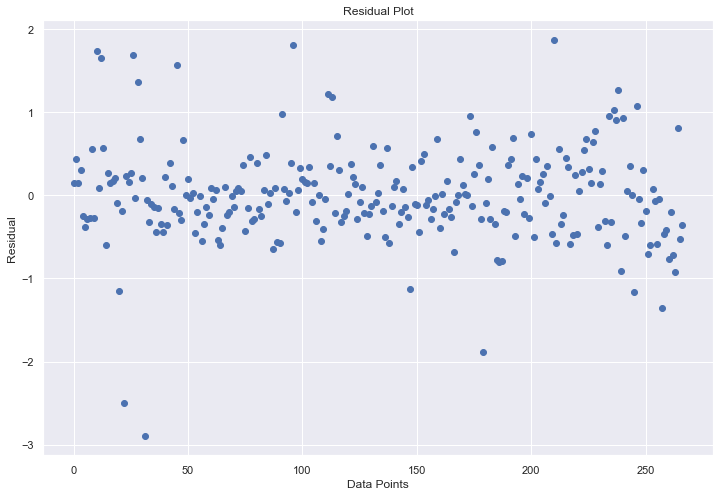

In [313]:
# Use statsmodels to plot the residuals
fit_select_lesser.resid.plot(style='o', figsize=(12,8));
plt.title('Residual Plot')
plt.xlabel('Data Points')
plt.ylabel('Residual');

**Despite a couple outliers, overall the residuals seem to be random and evenly distributed.**

Next steps:
- cross validation / testing
- look into high condition number
- look into regularization

### Results from SCIKIT-LEARN

R-Squared matches STATSMODELS result

In [314]:
# Create an empty model
lr1 = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# feature variables
X = X_select_lesser

# Choose the response variable(s)
y = df_train_filled.iloc[:,0]

# Fit the model to the full dataset
lr1.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr1.score(X, y)

0.5734539045572966

## We should also check to see if a polynomial model (with degree > 1) is necessary

### Visualizing Overfitting / the perfect polynomial degree model

In [315]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=8)

#NOTE: use 80% test to make a point of major generalization
#change `random_state` to see different results

Saving graph to: images/polynomial_check.svg


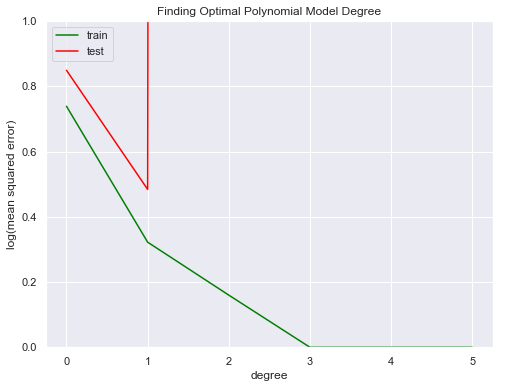

In [316]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 6 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.title('Finding Optimal Polynomial Model Degree')
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylim((0.0, 1))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left');

# Save options
save = 'images/polynomial_check'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

Per above graph, a polynomial model with degree = 1 is acceptable (basically Linear Regression Model)

## Train, Validate, and Test Model

In [317]:
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split # randomly creates test sets
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### check results with Train_Test_Split

- use 70% of data to train the model (training set)
- use 30% of data to test the model (test set)

In [318]:
# let's try fitting a training set + scoring test set
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=31)

lr1 = LinearRegression()

# fit training set into the lasso regression
lr1.fit(X_train,y_train)
lr1.score(X_test,y_test)

0.4877544219361143

### Post-split, let's use our training model to predict y-values and compare against y_test values

In [319]:
y_predict = lr1.predict(X_test)

In [320]:
y_predict[:10]

array([6.19636192, 5.91485871, 8.47326495, 6.48347468, 6.58814879,
       6.29589138, 6.28721443, 7.6560141 , 6.05171106, 6.43044682])

In [321]:
y_test[:10]

55     6.2
17     6.1
242    8.5
56     5.9
232    6.3
126    6.4
96     8.1
243    8.0
41     5.7
141    6.6
Name: gpuboss_score, dtype: float64

### By comparing y_predict vs. y_test, we see there are errors that exist. We can check the Mean Squared Errors via cross-validation techniques

In [322]:
# 5-fold cross-validation with data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=5, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.62296564 0.16821896 0.18836076 0.30751202 0.43633114]


### using cross-validation to capture R-squared results

In [323]:
# 5-fold cross-validation with data
reg = LinearRegression()
r2_avg = cross_val_score(reg, X, y, cv=5, scoring='r2').mean()

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(r2_avg)

0.40583674677001297


## Regularization - LASSO REGRESSION

Let's see if regularization is required (post feature selection). 

We shall see whether or not regularization will help reduce the mean squared error further.

May be ideal to utilize Lasso Regression if the goal is to reduce the number of features (to further simplify the model)

In [324]:
# feature variables (results from feature selection)
X = X_select_lesser

# Choose the response variable
y = df_train_filled.iloc[:,0]

### Try to find the best alpha for Lasso Regression

In [325]:
# using K-Folds to split the data into five training + test sets
kf = KFold(n=len(X), n_folds=5, shuffle=True) # shuffles the data

all_scores=[]
alphas=[1e-3,1e-2,1e-1,0,1,10,100] # alphas to test

# for each train / test set, fit and test against all five alphas Lasso Regression 
for train, test in kf:
    X_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(X_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

### Graph and see which alpha lowers the average Mean Squared Error the most

No handles with labels found to put in legend.


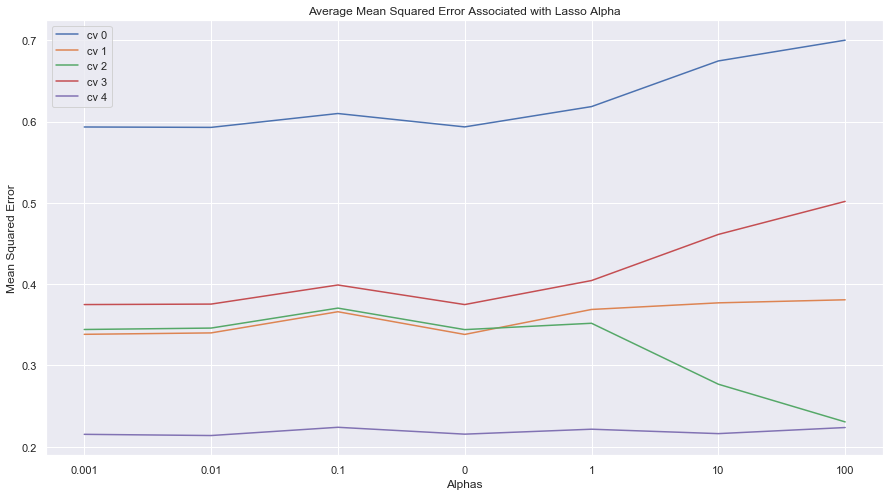

In [326]:
# Which alpha is the best for our model ? Looks like 10...
plt.figure(figsize=(15,8))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.title('Average Mean Squared Error Associated with Lasso Alpha')
plt.xlabel('Alphas')
plt.xticks(range(7),alphas)
plt.ylabel('Mean Squared Error')
plt.show()

### Based on above, hard to see what the optimal alpha would be. Let's try to see what specific alpha is optimal for Lasso Regression via GridSearchCV

In [327]:
from sklearn.model_selection import GridSearchCV

#Use GridSearchCV to evaluate optimal parameter
grid = GridSearchCV(Lasso(), param_grid={'alpha': np.linspace(1e-3, 100, 1000)})
grid.fit(X_train, y_train) # we will fit the training set (70% of dataset)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 1.01099e-01, ..., 9.98999e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### per GridSearchCV, the following is the optimal alpha:

In [328]:
grid.best_params_

{'alpha': 0.1010990990990991}

## Now we are going to see how Lasso Regression with alpha = 0.101099 improves / worsens the current linear model

### Graphical representation of GPU features' coefficients becoming zero (with alpha = 0.101099)

0.5469658247126405

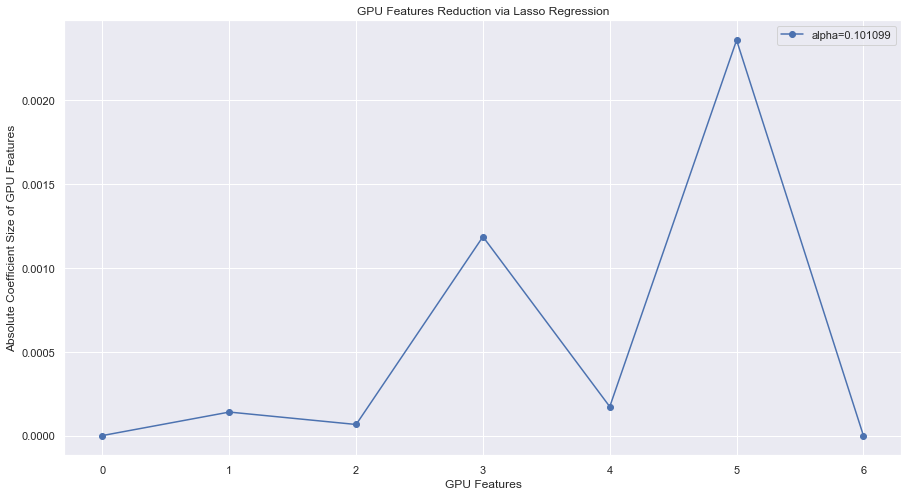

In [329]:
from sklearn.linear_model import Lasso

degree = 1
alpha = 0.101099

est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
est.fit(X_train, y_train)

# get coefs after fitting into Lasso Regression
coef = est.steps[-1][1].coef_.ravel()

plt.figure(figsize=(15,8))
plt.plot(np.abs(coef), marker='o', label='alpha=%r' % alpha)
plt.title('GPU Features Reduction via Lasso Regression')
plt.ylabel('Absolute Coefficient Size of GPU Features')
plt.xlabel('GPU Features')
plt.legend()

# Lasso Regression R-squared score
est.score(X_train,y_train)

### Let's see what are the strongest features, given a Lasso alpha = 0.101099

In [330]:
set_alpha = 0.101099

# fit training set into the lasso regression
est=Lasso(alpha=set_alpha)
est.fit(X_train,y_train)

# Take a look at our strongest features
zipped=zip(X.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:]

[('turbo_clock_speed_MHz', 0.0011865894155299835),
 ('shading_units', 0.0001722202816370087),
 ('passmark_score', 0.0001400676224495652),
 ('manhattan_gfx_score', 6.591763070492478e-05),
 ('Nvidia', 0.0),
 ('tdp_W', -0.0023591485030858205)]

In [331]:
est.coef_

array([ 1.40067622e-04,  6.59176307e-05,  1.18658942e-03,  1.72220282e-04,
       -2.35914850e-03,  0.00000000e+00])

### Per the results of Lasso (with alpha = 0.101099) - looks like we could remove one more feature

- Post Lasso, GPU feature 'Nvidia' was reduced with coefficient = 0

In [332]:
X_train.columns[5]

'Nvidia'

## compare Linear Regression vs. Lasso Regression

- use 70% of data to train the model (training set)
- use 30% of data to test the model (test set)

In [333]:
# split the data set into training + test sets
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=42)

### Linear Regression Performance

#### Fit the model

In [334]:
# standardize the features' values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Evaluate model scores with Cross Val
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5)
scores.mean()

0.45447115504799795

#### predict with test data

In [335]:
cross_val_model = model.fit(X_train,y_train)
y_predict_val = cross_val_model.predict(X_test)

#### mean squared error between y_test vs. y_predict - for Linear Regression Model

In [336]:
mean_squared_error(y_test.values,y_predict_val)

0.3712407983254999

### Lasso Regression Performance

#### fit the model

In [337]:
set_alpha = 0.101099

# fit training set into the lasso regression
est=Lasso(alpha=set_alpha)
lasso_model = est.fit(X_train,y_train)

#### Predict with test data

In [338]:
y_predict_lasso = lasso_model.predict(X_test)

#### mean squared error between y_test vs. y_predict - for Lasso Regression Model

In [339]:
mean_squared_error(y_test.values,y_predict_lasso)

0.392428782777205

In [340]:
lasso_model.score(X_test,y_test) # model score against test data

0.5419844518167385

In [341]:
#Evaluate model scores with Cross Val
scores = cross_val_score(est, X_train, y_train, cv=5,scoring='r2')
scores.mean()

0.4674442387441838

#### Although Lasso Regression has a higher mean squared error, we will stick with it given its ability to further simplify the model via its shrinkage ability (one less feature than linear regression model)


#### Overall, the result is Lasso Regression with R-Squared = 0.54 with a Mean Squared Error of 0.39.

# Below are other validations / feature transformations one can do to potentially optimize the model

### statsmodels 'fit_regularized' is equivalent to sklearn's Lasso/Ridge/ElasticNet

In [342]:
# statsmodel
import statsmodels.formula.api as smf

# define the model
lm_test = smf.ols('y~X',data=df_train_filled).fit_regularized(alpha=0.101099,L1_wt=1.0)

# check out the results
#fit_test.params

lm_test.params

Intercept    2.740679
X[0]         0.000068
X[1]         0.000105
X[2]         0.003395
X[3]         0.000115
X[4]        -0.001441
X[5]         0.000000
dtype: float64

### Cross-Validation: mean_squared_error for Lasso Regression

In [343]:
reg = Lasso(alpha=0.101099)
scores = cross_val_score(reg,X,y,cv=5,scoring='mean_squared_error')

print(-scores)

[0.66241048 0.15494181 0.17016677 0.34636308 0.50514015]


### Cross-Validation: R-squared (mean) for Lasso Regression

In [344]:
reg = Lasso(alpha=0.101099)
r2_avg = cross_val_score(reg, X, y, cv=5, scoring='r2').mean()

# check r2 average
print(r2_avg)

0.3903817176626739


## Plot each feature against the response variable (y) - see if transformation is needed

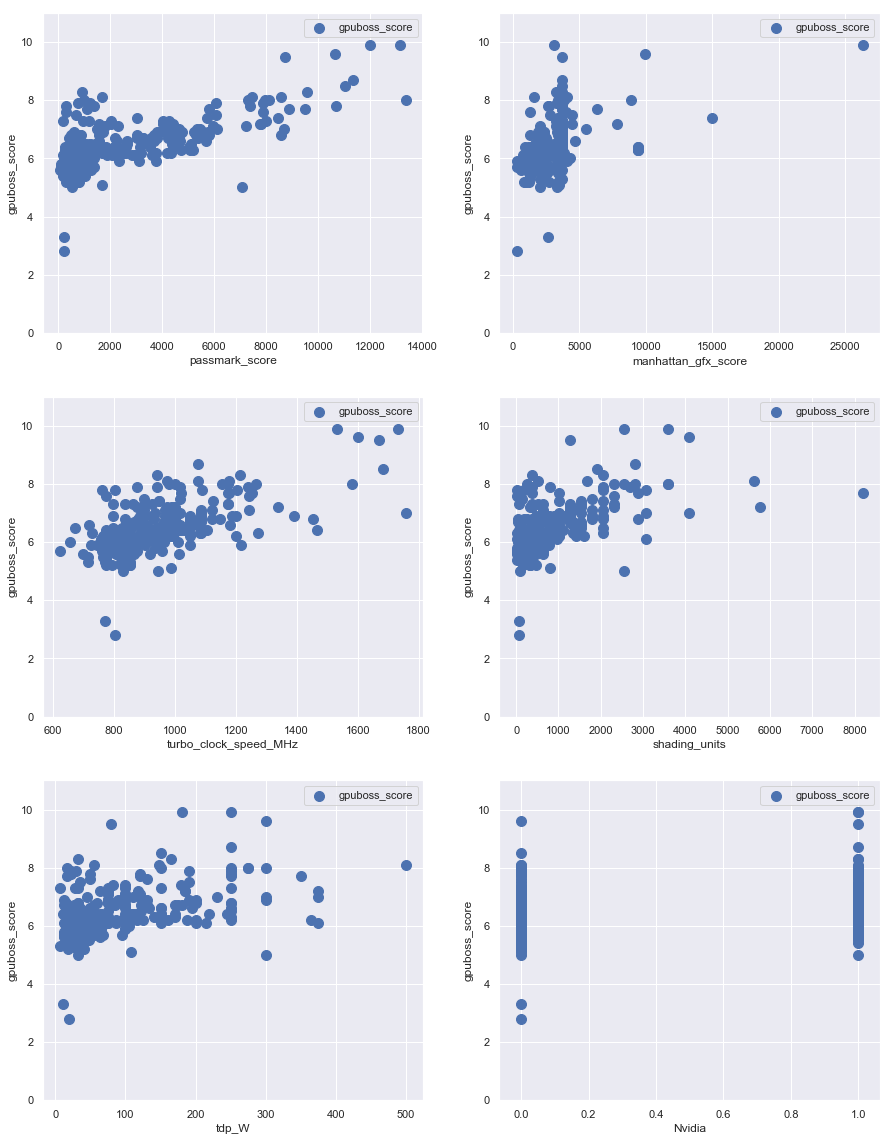

In [345]:
# Set up a figure and axes for 5 plots, 2 per row for 3 rows
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 20))

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(feature, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.scatter(X.iloc[:,feature], y, s=100)
    #ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((0, 11))
    #ax.set_xlim((0, 1))
    ax.set_ylabel('gpuboss_score')
    ax.set_xlabel(X.columns[feature])
    ax.legend(loc='upper right',frameon=True)

for feature in range(6):
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[feature//2]
    if feature%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(feature, ax, label='feature=%s' % X.columns[feature])

## quickly save latest dataframe via pickle

In [346]:
# concat the latest dataframe of GPU features with target variable
df_final = pd.concat([y,X],axis=1)

In [347]:
# save updated DataFrame with Pickle - dump into new file
with open('data/df_final.pkl','wb') as picklefile:
    pickle.dump(df_final,picklefile)

In [348]:
# load pickle file
with open('data/df_final.pkl','rb') as picklefile:
    df_final = pickle.load(picklefile)

In [349]:
df_final.head(3)

,gpuboss_score,passmark_score,manhattan_gfx_score,turbo_clock_speed_MHz,shading_units,tdp_W,Nvidia
0,6.2,739.0,2476.275617,828.219279,64.0,95.0,1.0
1,6.4,1028.0,2831.877443,855.228903,800.0,110.0,0.0
2,6.2,716.0,2800.568477,851.229285,112.0,125.0,1.0


## Trying Log Transformation here:

In [350]:
# log transform features 

# passmark_score
df_final.iloc[:,1] = df_final.iloc[:,1].apply(np.log)

# manhattan_gfx_score
df_final.iloc[:,2] = df_final.iloc[:,2].apply(np.log)

# turbo_clock_speed_MHz
df_final.iloc[:,3] = df_final.iloc[:,3].apply(np.log)

# shading_units
df_final.iloc[:,4] = df_final.iloc[:,4].apply(np.log)

# tdp_W
df_final.iloc[:,5] = df_final.iloc[:,5].apply(np.log)

df_final.head(3)

,gpuboss_score,passmark_score,manhattan_gfx_score,turbo_clock_speed_MHz,shading_units,tdp_W,Nvidia
0,6.2,6.605298,7.814511,6.719278,4.158883,4.553877,1.0
1,6.4,6.935370,7.948695,6.751369,6.684612,4.700480,0.0
2,6.2,6.573680,7.937578,6.746682,4.718499,4.828314,1.0


In [351]:
# set log-features matrix + response variable
X_reduced_3 = df_final.iloc[:,1:]
y = df_final.iloc[:,0]

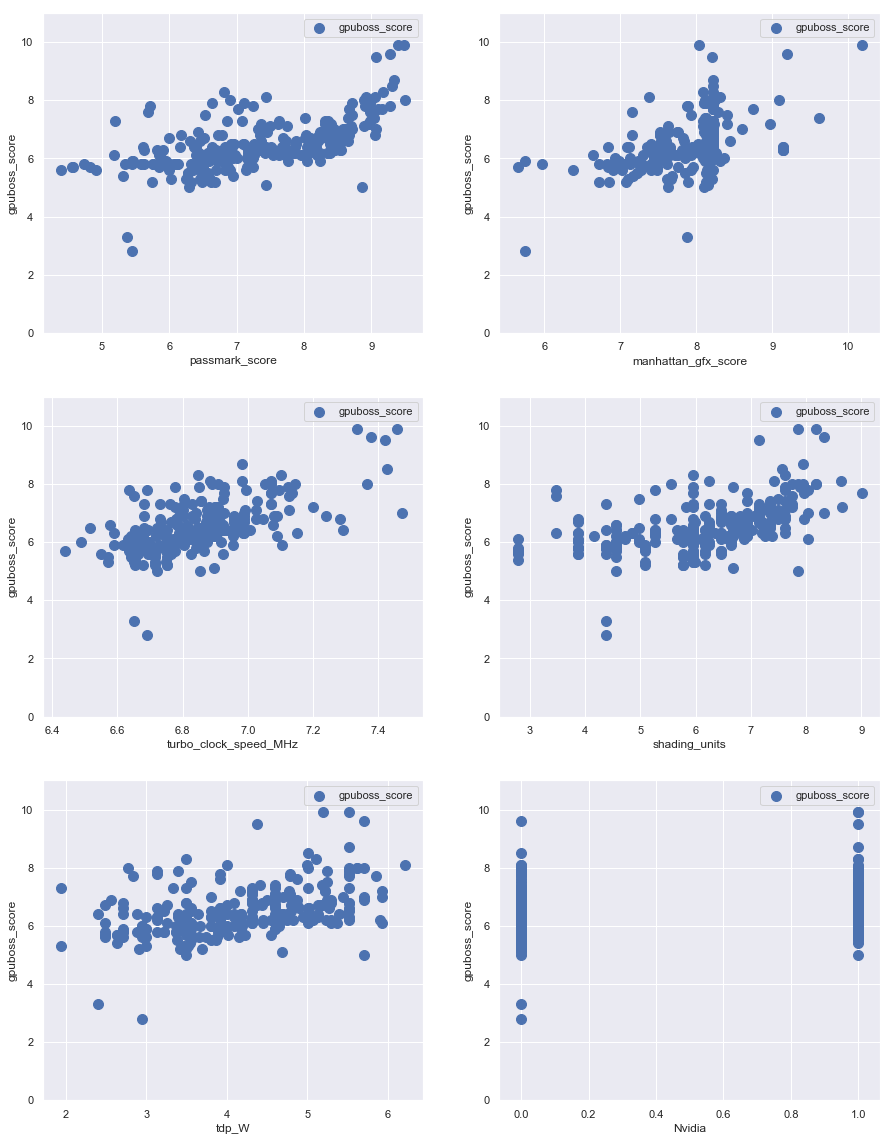

In [352]:
# Set up a figure and axes for 5 plots, 2 per row for 3 rows
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 20))

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(feature, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    #ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_reduced_3.iloc[:,feature], y, s=100)
    #ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((0, 11))
    #ax.set_xlim((0, 1))
    ax.set_ylabel('gpuboss_score')
    ax.set_xlabel(X_reduced_3.columns[feature])
    ax.legend(loc='upper right',frameon=True)

for feature in range(6):
    #est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    #est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[feature//2]
    if feature%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(feature, ax, label='feature=%s' % X_reduced_3.columns[feature])

## log features seem like a better fit - let's check with statsmodel

Notice how Condition Number + Kurtosis have decreased, relative to model prior to log transformation

In [353]:
# Define the model
lm5 = smf.ols('y ~ X_reduced_3',data=df_final)

# Fit the model
fit5 = lm5.fit()

# Check out the results
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     45.60
Date:                Sat, 20 Oct 2018   Prob (F-statistic):           5.91e-38
Time:                        16:50:08   Log-Likelihood:                -246.81
No. Observations:                 267   AIC:                             507.6
Df Residuals:                     260   BIC:                             532.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -8.7153      1.860     -4.686      0.000     -12.378      -5.053
X_reduced_3[0]     0.2493      0.117      2.123      0.035       0.018       0.480
X_reduced_3[1]     0.1936      0.088      2.198      0.029       0.020       0.367
X_reduced_3[2]     1.7040      0.307      5.556      0.000       1.100       2.308
X_reduced_3[3]     0.1075      0.076      1.418      0.157      -0.042       0.257
X_reduced_3[4]    -0.1530      0.082     -1.859      0.064      -0.315       0.009
X_reduced_3[5]     0.3568      0.086      4.130      0.000       0.187       0.527
==============================================================================
Omnibus:                       19.697   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.379
Skew:                           0.282   Prob(JB):                     1.89e-11
Kurtosis:                       5.030   Cond. No.                         739.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## check with cross-validation

In [354]:
# 5-fold cross-validation with data
reg = LinearRegression()
scores = cross_val_score(reg, X_reduced_3, y, cv=5, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.81739295 0.19927226 0.23025373 0.30617323 0.64468852]


In [355]:
# 5-fold cross-validation with current data set
reg = LinearRegression()
r2_avg = cross_val_score(reg, X_reduced_3, y, cv=5, scoring='r2').mean()

# check r2 average
print(r2_avg)

0.26699338030061354


## check regression is linear in parameters & correctly specified

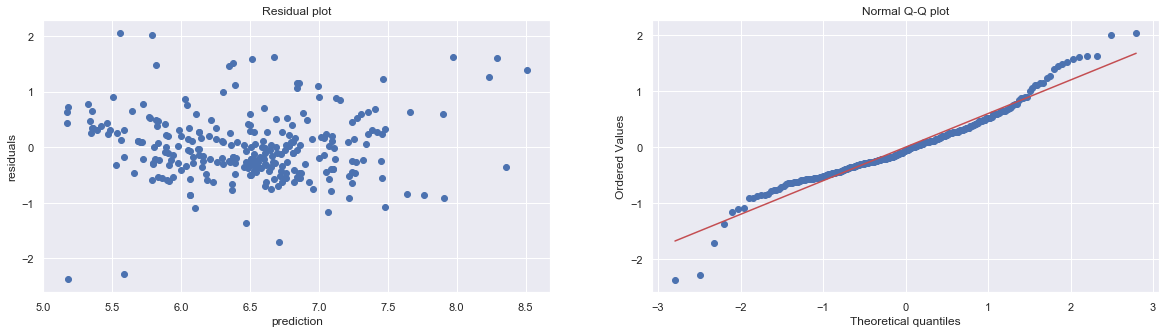

In [356]:
import scipy.stats as stats # for Q-Q plot + box-cox

plt.figure(figsize=(20,5))

rgr = LinearRegression()
rgr.fit(X_reduced_3,y)
pred = rgr.predict(X_reduced_3)

# regression plot
res = y - pred
plt.subplot(1,2,1)
plt.scatter(pred,res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

# Q-Q plot; if plot looks crazy, something is wrong
# Generates a probability plot of sample data against the quantiles of a 
#specified theoretical distribution 
plt.subplot(1,2,2)
stats.probplot(res,dist='norm',plot=plt)
plt.title("Normal Q-Q plot");

# Let's see if Box-Cox method is better than log transformation

In [357]:
# load pickle file - df_final
with open('data/df_final.pkl','rb') as picklefile:
    df_final = pickle.load(picklefile)

## check the error term has constant variance (Box-Cox method)

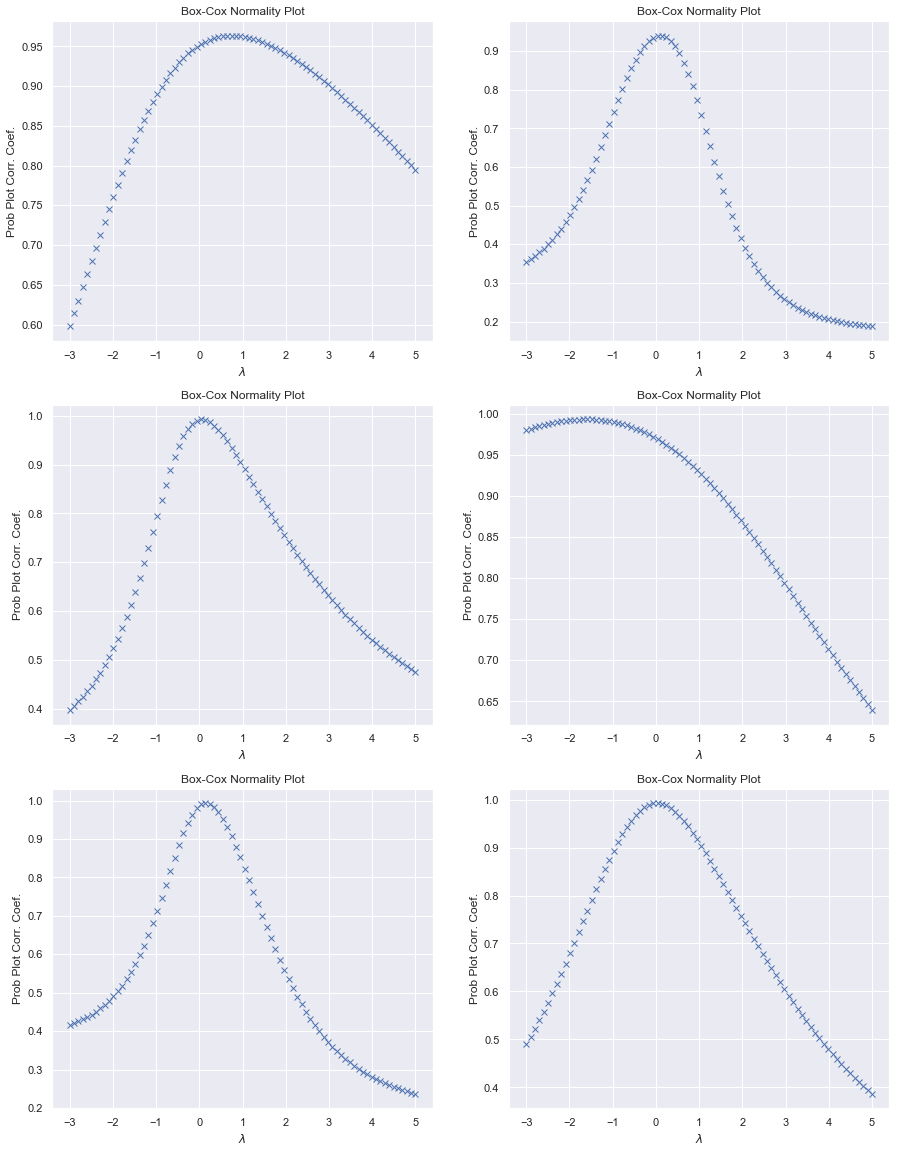

In [358]:
# box-cox

fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(321)
prob = stats.boxcox_normplot(df_final.gpuboss_score,-3,5,plot=ax) # gpuboss_score

ax = fig.add_subplot(322)
prob = stats.boxcox_normplot(df_final.manhattan_gfx_score,-3,5,plot=ax) # manhattan_gfx_score

ax = fig.add_subplot(323)
prob = stats.boxcox_normplot(df_final.passmark_score,-3,5,plot=ax) # passmark_score

ax = fig.add_subplot(324)
prob = stats.boxcox_normplot(df_final.turbo_clock_speed_MHz,-3,5,plot=ax) # turbo_clock_speed_MHz

ax = fig.add_subplot(325)
prob = stats.boxcox_normplot(df_final.shading_units,-3,5,plot=ax) # shading units

ax = fig.add_subplot(326)
prob = stats.boxcox_normplot(df_final.tdp_W,-3,5,plot=ax) # tdp_W

### Loop to box-cox transform every feature + response variable

In [359]:
# box-cox transform all features + response variable
for feature in range(6):
    lamb = stats.boxcox_normmax(df_final.iloc[:,feature],brack=(-1.9,1.9))
    df_final.iloc[:,feature] = (np.power(df_final.iloc[:,feature],lamb)-1)/lamb

In [360]:
# set log-features matrix + response variable
X_reduced_4 = df_final.iloc[:,1:]
y_4 = df_final.iloc[:,0]

## Histograms of response variable + every feature

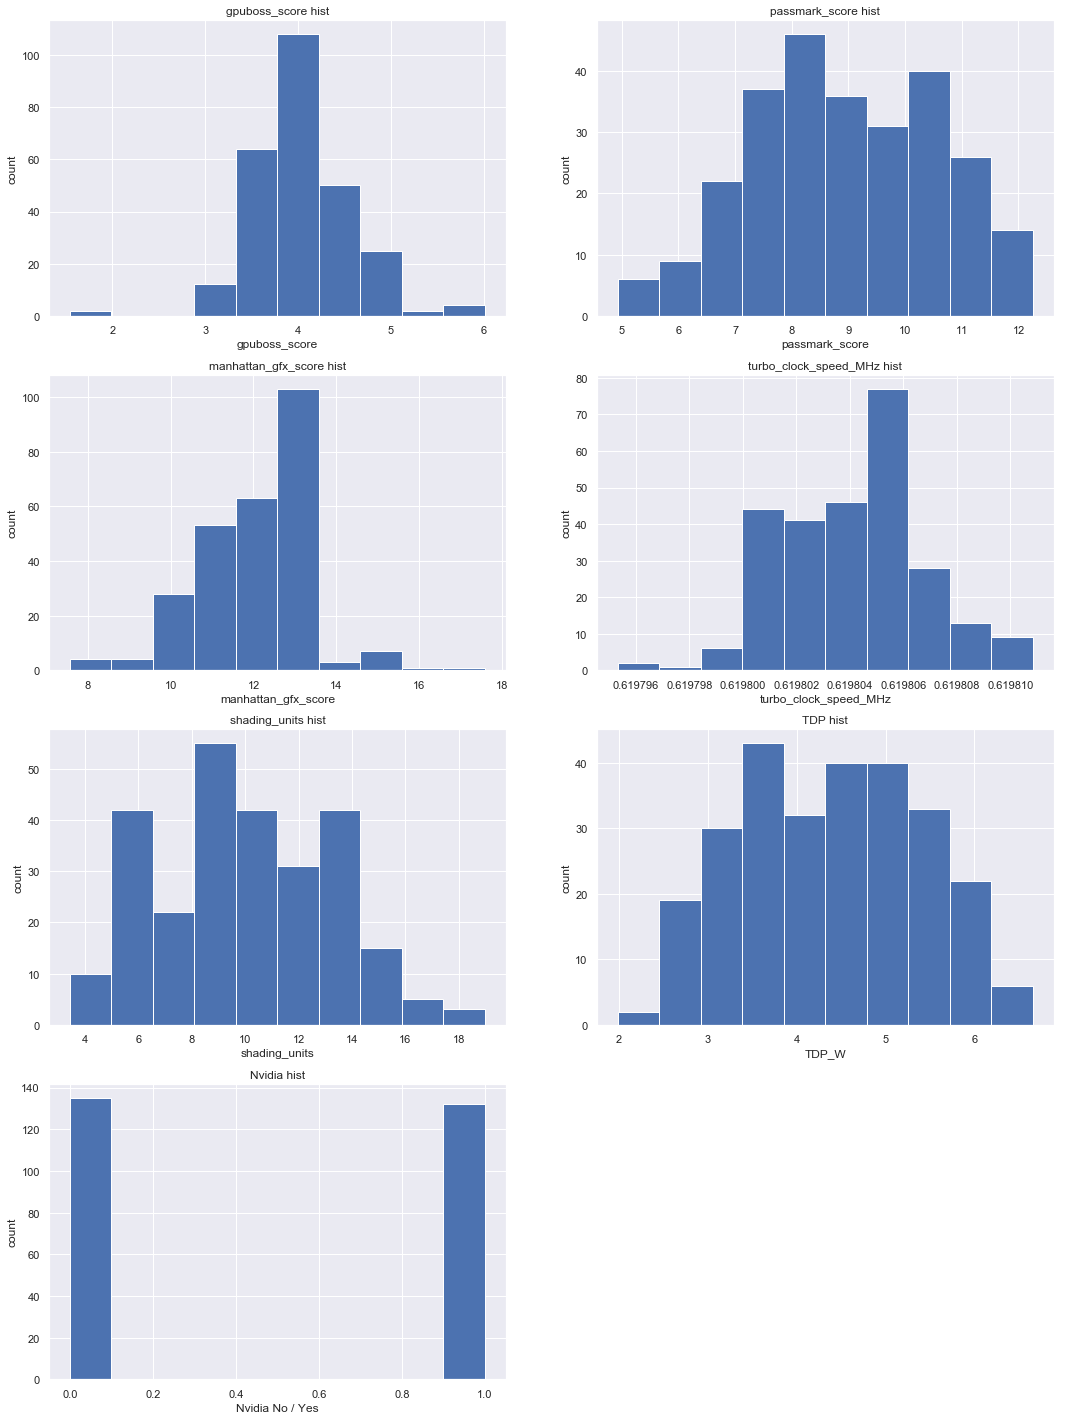

In [361]:
#histogram of all features + response variable
plt.figure(figsize=(18,25))

# regression plot
plt.subplot(4,2,1)
plt.hist(df_final.gpuboss_score)
plt.title("gpuboss_score hist")
plt.xlabel("gpuboss_score")
plt.ylabel("count")

plt.subplot(4,2,2)
plt.hist(df_final.passmark_score)
plt.title("passmark_score hist")
plt.xlabel("passmark_score")
plt.ylabel("count")

plt.subplot(4,2,3)
plt.hist(df_final.manhattan_gfx_score)
plt.title("manhattan_gfx_score hist")
plt.xlabel("manhattan_gfx_score")
plt.ylabel("count")

plt.subplot(4,2,4)
plt.hist(df_final.turbo_clock_speed_MHz)
plt.title("turbo_clock_speed_MHz hist")
plt.xlabel("turbo_clock_speed_MHz")
plt.ylabel("count")

plt.subplot(4,2,5)
plt.hist(df_final.shading_units)
plt.title("shading_units hist")
plt.xlabel("shading_units")
plt.ylabel("count")

plt.subplot(4,2,6)
plt.hist(df_final.tdp_W)
plt.title("TDP hist")
plt.xlabel("TDP_W")
plt.ylabel("count");

plt.subplot(4,2,7)
plt.hist(df_final.Nvidia)
plt.title("Nvidia hist")
plt.xlabel("Nvidia No / Yes")
plt.ylabel("count");

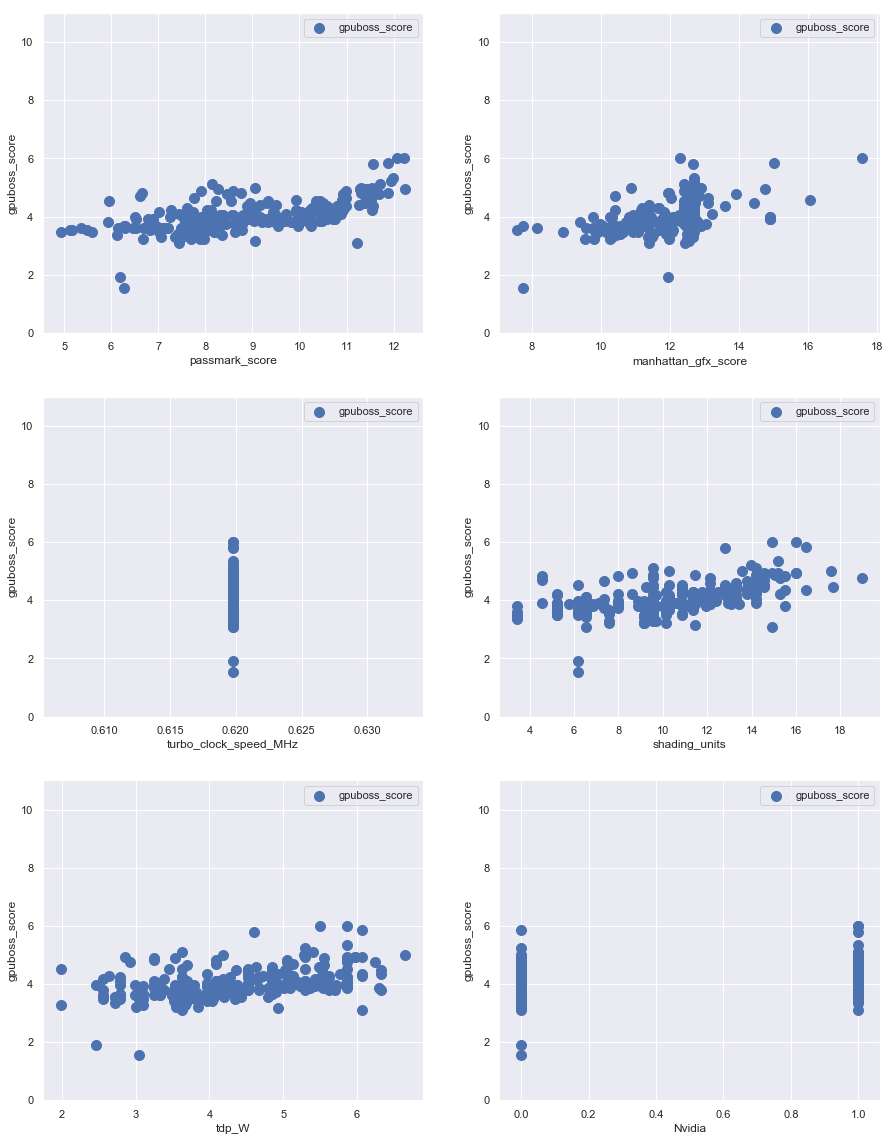

In [362]:
# Set up a figure and axes for 5 plots, 2 per row for 3 rows
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 20))

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(feature, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.scatter(X_reduced_4.iloc[:,feature], y_4, s=100)
    ax.set_ylim((0, 11))
    #ax.set_xlim((0, 1))
    ax.set_ylabel('gpuboss_score')
    ax.set_xlabel(X_reduced_4.columns[feature])
    ax.legend(loc='upper right',frameon=True)

for feature in range(6):
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[feature//2]
    if feature%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(feature, ax, label='feature=%s' % X_reduced_4.columns[feature])

### Residual Plot + Q-Q Plot (for Box-Cox Method)

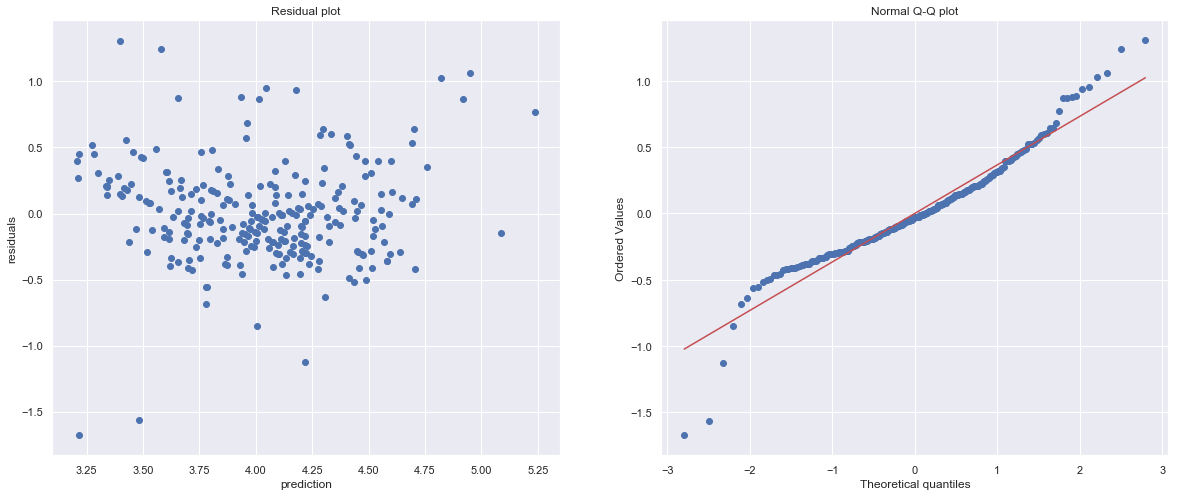

In [363]:
plt.figure(figsize=(20,8))

rgr = LinearRegression()
rgr.fit(X_reduced_4,y_4)
pred = rgr.predict(X_reduced_4)

# regression plot
res = y_4 - pred
plt.subplot(1,2,1)
plt.scatter(pred,res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

# Q-Q plot; if plot looks crazy, something is wrong
# Generates a probability plot of sample data against the quantiles of a 
#specified theoretical distribution 
plt.subplot(1,2,2)
stats.probplot(res,dist='norm',plot=plt)
plt.title("Normal Q-Q plot");

## statsmodel summary of box-cox transformed features

Looks like log transformation is a better fit than box-cox method

In [364]:
# Define the model
lm6 = smf.ols('y_4 ~ X_reduced_4',data=df_final)

# Fit the model
fit6 = lm6.fit()

# Check out the results
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_4   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     45.10
Date:                Sat, 20 Oct 2018   Prob (F-statistic):           1.22e-37
Time:                        16:50:12   Log-Likelihood:                -116.35
No. Observations:                 267   AIC:                             246.7
Df Residuals:                     260   BIC:                             271.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.365e+04   7769.915     -4.331      0.000   -4.89e+04   -1.83e+04
X_reduced_4[0]     0.1114      0.047      2.364      0.019       0.019       0.204
X_reduced_4[1]     0.0591      0.025      2.372      0.018       0.010       0.108
X_reduced_4[2]  5.429e+04   1.25e+04      4.331      0.000    2.96e+04     7.9e+04
X_reduced_4[3]     0.0462      0.019      2.428      0.016       0.009       0.084
X_reduced_4[4]    -0.1279      0.046     -2.800      0.005      -0.218      -0.038
X_reduced_4[5]     0.2415      0.052      4.663      0.000       0.140       0.343
==============================================================================
Omnibus:                       24.668   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.067
Skew:                           0.081   Prob(JB):                     2.52e-23
Kurtosis:                       6.054   Cond. No.                     1.20e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Heatmap for correlations

In [365]:
df_final = pd.concat([y,X],axis=1)
df_final.head(3)

,gpuboss_score,passmark_score,manhattan_gfx_score,turbo_clock_speed_MHz,shading_units,tdp_W,Nvidia
0,6.2,739.0,2476.275617,828.219279,64.0,95.0,1.0
1,6.4,1028.0,2831.877443,855.228903,800.0,110.0,0.0
2,6.2,716.0,2800.568477,851.229285,112.0,125.0,1.0


##  Final heatmap of features against response variable

Saving graph to: images/final_corr_heatmap.svg


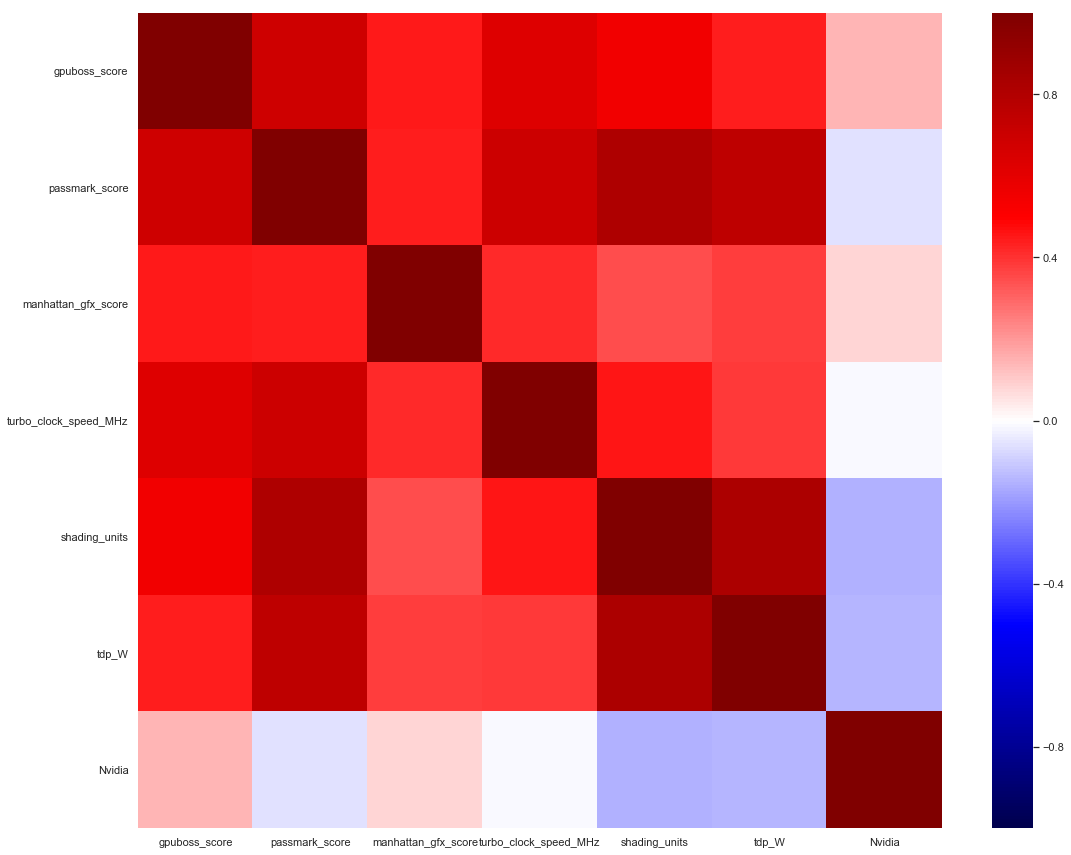

In [366]:
# example of a better corr matrix
plt.figure(figsize=(18,15))  
sns.heatmap(df_final.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

# Save options
save = 'images/final_corr_heatmap'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')